# AEM Content Theme Clustering

Assigning relevant content theme tags to Invesco US insights pages using unsupervised machine learning algorithms.

## Data Exploration

### Loading AEM Data

Importing data provided by the Invesco Web team. This is a csv file that contains information on all pages published to the Adobe Experience Manager platform.

In [15]:
import pandas as pd
import os

In [16]:
df = pd.read_csv('data/US_Node_Report.csv')

### Initial Examination of Data

First we will take a high level glance at the structure of our data. We are looking for several indicators, among others, that will determine how we proceed:

- Size of the initial dataset
- Feature datatypes
- Feature relevance
- Null values

#### Data Shape & Initial Implications

Let's take a look at the shape of our data. This will provide us with a base level understanding of the relative dataset size, which we can further analyze.

In [17]:
df.shape

(1037, 11)

Our data contains 11 feature columns and a total of 1037 rows. This tells us that our dataset may not be particularly robust enough for a fully fledged implementation of K-Means, which depends heavily on the volume and cleanliness of the underlying data.

Underfitting is a potential roadblock because our training data is unlikely to be representative of the population. This can be solved, however, through feature engineering, supplemental data collection, and/or implementing a more complex algorithm.

Underfitting is of relatively little concern in this case because our analysis is focused squarely on Invesco AEM Insights content which, in turn, becomes the population. This content can be thought of as blog-like in nature. This means that the population itself is small. Additionally, this clustering is meant to generate a starting point for discussions with segment marketing teams on what theme tags to include in our final definitive list rather than to construct a model that can predict cluster adherance reliably.

With that being said, overfitting is our primary concern. The lack of robust data to both train and test on means that the algorithm is much more likely to function as an instance would, as opposed to a model - effectively memorizing content as opposed to creating a framework that supports broad generalization.

#### Dataset Feature Examination

Getting a list of indexed feature names and data types.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Path                1037 non-null   object
 1   Title               1037 non-null   object
 2   Template            1037 non-null   object
 3   Last Modified       1037 non-null   object
 4   Tags                17 non-null     object
 5   Topic Tags          806 non-null    object
 6   Program tags        134 non-null    object
 7   Theme tags          309 non-null    object
 8   Content type tags   949 non-null    object
 9   User role tags      946 non-null    object
 10  Replication Status  1037 non-null   object
dtypes: object(11)
memory usage: 89.2+ KB


A few things come to our attention right off the bat - some being simple best practices and others having to do with decision making for this analysis.

##### Feature Names Should Be Normalized

Feature names should be normalized (it's always a pain when you can't slice data because you have to fiddle with casing and white space)

##### Most Features Aren't Relevant

I suppose saying that most features aren't relevant isn't entirely accurate. A more descript way to put that is: most features should not be included in this analysis because of either their irrelevancy to our business case or they could have ramifications on model performance if they were to be included.

Let's take a first look at our data so we can better understand what we're working with

In [19]:
# visual inspection of sample data
df.head()

,Path,Title,Template,Last Modified,Tags,Topic Tags,Program tags,Theme tags,Content type tags,User role tags,Replication Status
0,/content/invesco/us/en/error,Error,/conf/invesco/settings/wcm/templates/blank-pag...,"Mon, 26 Aug 2019 13:09:12 +0000",NaN,NaN,NaN,NaN,NaN,NaN,NOT_ACTIVATED
1,/content/invesco/us/en/header,Header,/conf/invesco/settings/wcm/templates/header-te...,"Mon, 19 Aug 2019 22:13:02 +0000",NaN,NaN,NaN,NaN,NaN,NaN,NOT_ACTIVATED
2,/content/invesco/us/en/insights/topic,Topic,/conf/invesco/settings/wcm/templates/blank-pag...,"Tue, 15 Sep 2020 09:29:39 +0000",NaN,NaN,NaN,NaN,NaN,NaN,NOT_ACTIVATED
3,/content/invesco/us/en/footer,Footer,/conf/invesco/settings/wcm/templates/footer-te...,"Thu, 1 Oct 2020 15:02:41 +0000",NaN,NaN,NaN,NaN,NaN,NaN,NOT_ACTIVATED
4,/content/invesco/us/en/forms/dc-contact-us-form,dc-contact-us-form,/conf/invesco/settings/wcm/templates/form-page...,"Fri, 2 Oct 2020 19:28:02 +0000",NaN,NaN,NaN,NaN,NaN,NaN,NOT_ACTIVATED


**Operationalizing irrelevant features:**

Features that are surmised to have little to no impact on an outcome for our business case. If a feature doesn't have anything to do with the content itself, it will likely be an unwise inclusion in our model training steps. We want to avoid having the model's performance being tied to features that wouldn't be a part of the content segmentation process normally. An example of this would be the *Replication Status* column.

***TODO: SHOW EXAMPLE OF REPLICATION STATUS DATA TO ILLUSTRATE THE POINT ABOVE***

Furthermore, there are features that are relevant to feature engineering or data cleansing, but are irrelevant in the eyes of our model. Consider the *Template* and *User Role* features. Both of these features could be critical to properly cleaning our dataset but not of any importance in training a model that can group similar content together.

TODO: SHOW EXAMPLE OF TEMPLATE AND USER ROLE DATA TO ILLUSTRATE THE POINT ABOVE

***TODO: COMPLETE FEATURE INCLUSION SECTION BY DESCRIBING HOW THEY COULD NEGATIVELY IMPACT MODEL PERFORMANCE***

In [6]:
# there are is alot of missing data - do a quick count NaN by column (inverse of df.info() result)
df.isna().sum()

Path                     0
Title                    0
Template                 0
Last Modified            0
Tags                  1020
Topic Tags             231
Program tags           903
Theme tags             728
Content type tags       88
User role tags          91
Replication Status       0
dtype: int64

#### Investigating Existing Tags

In [7]:
# see what theme tags currently exist - ignoring nan at index 0
theme_tags = df["Theme tags"].unique().tolist()[1:]
theme_tags

['Elections',
 'Investment solutions',
 'Macroeconomics & outlook',
 'Government regulation & legislation',
 'Coronavirus',
 'Diversifying income;Managing volatility;Targeting growth',
 'Managing volatility;Market & Investing Dynamics',
 'Targeting growth',
 'Investor education;Market behavior   commentary;Market & Investing Dynamics',
 'Research',
 'Your practice',
 'College savings',
 'Market behavior   commentary',
 'Your clients',
 'Diversifying income',
 'Your portfolio',
 'Market behavior   commentary;Macroeconomics & outlook;Aging Demographics',
 'Macroeconomics & outlook;Elections',
 'Market behavior   commentary;Macroeconomics & outlook',
 'Solutions',
 'Coronavirus;Government regulation & legislation',
 'Government regulation & legislation;Coronavirus',
 'Coronavirus;Macroeconomics & outlook',
 'Factor investing',
 'Retirement planning',
 'Managing volatility',
 'Targeting growth;Factor investing',
 'Factor investing;Investment solutions;Market & Investing Dynamics',
 'Factor

##### Splitting Theme Tags

In [8]:
# theme tags aren't unique due to nesting
# unnest them

# list to store each individual tag - not unique
split_theme_tags = list()

# iterate
for tag_group in theme_tags:
  # split string by common separator
  tag_list = tag_group.split(";")
  for tag in tag_list:
    # add split strings to the list above
    split_theme_tags.append(tag)

# split_theme_tags
  

##### Dropping Nonunique Theme Tags

In [9]:
# use set to drop nonunique strings
split_theme_tag_set = set(split_theme_tags)

In [10]:
# decresed theme tag count by 17
len(theme_tags) - len(split_theme_tag_set)

17

In [11]:
# left with 22 unique theme tags that are currently in use
len(split_theme_tag_set)

22

In [12]:
split_theme_tag_set

{'Aging Demographics',
 'College savings',
 'Coronavirus',
 'Diversifying income',
 'Elections',
 'Factor investing',
 'Government regulation & legislation',
 'Innovation',
 'Investment solutions',
 'Investor education',
 'Macroeconomics & outlook',
 'Managing volatility',
 'Market & Investing Dynamics',
 'Market behavior   commentary',
 'Research',
 'Retirement planning',
 'Russia Ukraine crisis',
 'Solutions',
 'Targeting growth',
 'Your clients',
 'Your portfolio',
 'Your practice'}

#### Data Summarization

In [13]:
df.describe()

,Path,Title,Template,Last Modified,Tags,Topic Tags,Program tags,Theme tags,Content type tags,User role tags,Replication Status
count,1037,1037,1037,1037,17,806,134,309,949,946,1037
unique,1037,966,14,1035,12,139,11,39,15,60,1
top,/content/invesco/us/en/error,Events,/conf/invesco/settings/wcm/templates/article-p...,"Wed, 3 Feb 2021 17:25:27 +0000",Markets and Economy,Markets and Economy,Rapid Response,Your practice,Insight,Institutional,NOT_ACTIVATED
freq,1,4,655,3,5,193,34,58,607,243,1037


## Cleaning AEM Dataset

### Dropping Unnecessary Columns

#### Template Series

`Template` is nothing more than a mapped abstraction of the user defined boilerplate used to constrcut the content that exists at a given public path. The methodolgy for how the content is structured by the Content Management Platform is not of consequence to our analysis.

> ***Important Note:***  
*This could be of use in identifying the HTML tags that need to be accessed by the web scraper, however that would only be applicable if we had access to those backend layouts. This can be ignored unless the HTML content is extraordinarily complex.*. 

For this reason, the `Template` series can be dropped from the dataframe.





## Scraping AEM Content

In [14]:
# imports
from bs4 import BeautifulSoup
import requests
import numpy as np
from requests.models import Response

In [15]:
# keep only insights rows
df = df[df["Content type tags"] == "Insight"].reset_index(drop=True)
df.head()

,Path,Title,Template,Last Modified,Tags,Topic Tags,Program tags,Theme tags,Content type tags,User role tags,Replication Status
0,/content/invesco/us/en/insights/election-2020-...,Election 2020: The Senate is definitely in play,/conf/invesco/settings/wcm/templates/article-p...,"Tue, 3 Nov 2020 15:06:30 +0000",NaN,Legislative and regulatory;Washington update;P...,Election 2020,Elections,Insight,Institutional,NOT_ACTIVATED
1,/content/invesco/us/en/insights/tactical-asset...,Tactical asset allocation outlook: November 2020,/conf/invesco/settings/wcm/templates/article-p...,"Wed, 25 Nov 2020 15:12:43 +0000",NaN,Multi Asset;Asset allocation;Markets and Economy,Solutions,Investment solutions,Insight,Institutional,NOT_ACTIVATED
2,/content/invesco/us/en/insights/2021-outlook-i...,2021 Investment Outlook: Implications for worl...,/conf/invesco/settings/wcm/templates/article-p...,"Tue, 1 Dec 2020 10:05:35 +0000",NaN,Market outlook,NaN,Macroeconomics & outlook,Insight,Institutional,NOT_ACTIVATED
3,/content/invesco/us/en/insights/shifting-dc-ti...,Shifting DC Times: Helping women close the ret...,/conf/invesco/settings/wcm/templates/article-p...,"Mon, 14 Dec 2020 16:46:55 +0000",NaN,Participant engagement;Defined contribution,Shifting DC Times,NaN,Insight,Financial Professional;Institutional;EDJONES;PFS,NOT_ACTIVATED
4,/content/invesco/us/en/insights/shifting-dc-ti...,Shifting DC Times: Fiduciary fails to avoid,/conf/invesco/settings/wcm/templates/article-p...,"Mon, 4 Jan 2021 21:48:11 +0000",NaN,Plan governance;Defined contribution,Shifting DC Times,NaN,Insight,Financial Professional;Institutional;EDJONES;PFS,NOT_ACTIVATED


Reformat user role tags as lists by leveraging the existing semicolon delimiter.

In [16]:
# format user role tags as list

def reformat(x):
  """Reformat the passed string as a list by splitting on the delimiter ';'

  :param x: string of role tags or any string delimited by ';'
  :type x: str
  :return: list of role tags
  """
  return x.split(';')

df["User role tags"] = df["User role tags"].apply(reformat)
df.head()

,Path,Title,Template,Last Modified,Tags,Topic Tags,Program tags,Theme tags,Content type tags,User role tags,Replication Status
0,/content/invesco/us/en/insights/election-2020-...,Election 2020: The Senate is definitely in play,/conf/invesco/settings/wcm/templates/article-p...,"Tue, 3 Nov 2020 15:06:30 +0000",NaN,Legislative and regulatory;Washington update;P...,Election 2020,Elections,Insight,[Institutional],NOT_ACTIVATED
1,/content/invesco/us/en/insights/tactical-asset...,Tactical asset allocation outlook: November 2020,/conf/invesco/settings/wcm/templates/article-p...,"Wed, 25 Nov 2020 15:12:43 +0000",NaN,Multi Asset;Asset allocation;Markets and Economy,Solutions,Investment solutions,Insight,[Institutional],NOT_ACTIVATED
2,/content/invesco/us/en/insights/2021-outlook-i...,2021 Investment Outlook: Implications for worl...,/conf/invesco/settings/wcm/templates/article-p...,"Tue, 1 Dec 2020 10:05:35 +0000",NaN,Market outlook,NaN,Macroeconomics & outlook,Insight,[Institutional],NOT_ACTIVATED
3,/content/invesco/us/en/insights/shifting-dc-ti...,Shifting DC Times: Helping women close the ret...,/conf/invesco/settings/wcm/templates/article-p...,"Mon, 14 Dec 2020 16:46:55 +0000",NaN,Participant engagement;Defined contribution,Shifting DC Times,NaN,Insight,"[Financial Professional, Institutional, EDJONE...",NOT_ACTIVATED
4,/content/invesco/us/en/insights/shifting-dc-ti...,Shifting DC Times: Fiduciary fails to avoid,/conf/invesco/settings/wcm/templates/article-p...,"Mon, 4 Jan 2021 21:48:11 +0000",NaN,Plan governance;Defined contribution,Shifting DC Times,NaN,Insight,"[Financial Professional, Institutional, EDJONE...",NOT_ACTIVATED


In [17]:
# remove solutions and test paths
df = df[df["Path"].str.contains("solutions|test") == False]
# reformat path to live url
df["Full Path"] = "https://www." + df["Path"].str.replace(r'/content/invesco', 'invesco.com') + ".html"
full_path_list = df["Full Path"].tolist()
# full_path_list

In [18]:
# get list of user role tags
role_tag_list = df["User role tags"].tolist()
# role_tag_list

In [19]:
# zip two lists together
extraction_list = list(zip(full_path_list, role_tag_list))

In [20]:
from typing import Union, Type

def request(url: str, audience_role:str) -> Type[Response]:
  return requests.get(url + f'?audienceRole={audience_role}')   

In [21]:
# google colab implementation
# from tqdm.notebook import tqdm

In [22]:
# local jupyter implementation
from tqdm import tqdm

Concurrent requests:

```python


# get status codes of all urls
status_codes = list()
# get html content of all urls
html_content = list()

for item in tqdm(extraction_list):
  url, roles = item
  if 'Individual Investor' in roles:
    response = request(url, 'IndividualInvestor')
    status_codes.append(response.status_code)
    html_content.append(response.content)
  elif 'Financial Professional' in roles:
    response = request(url, 'FinancialProfessional')
    status_codes.append(response.status_code)
    html_content.append(response.content)
  elif 'Institutional' in roles:
    response = request(url, 'Institutional')
    status_codes.append(response.status_code)
    html_content.append(response.content)
  else:
    status_codes.append(np.nan)
```

Takes 5 minutes 43 seconds to complete 586 iterations. Opted for a multi-threaded approach instead to speed this up greatly for future runs of this analysis. New approach shown below is approximately 5 times faster with thread pooling.


In [23]:
# lists to store retrieved data
status_codes = list()
html_content = list()

In [24]:
# MULTI-THREADED REQUESTS

from concurrent.futures import ThreadPoolExecutor

def request_with_role(url_and_role: tuple) -> None:
  url, roles = url_and_role
  if 'Individual Investor' in roles:
    response = request(url, 'IndividualInvestor')
    return tuple((response.status_code, response.content.decode('utf-8')))
  elif 'Financial Professional' in roles:
    response = request(url, 'FinancialProfessional')
    return tuple((response.status_code, response.content.decode('utf-8')))
  elif 'Institutional' in roles:
    response = request(url, 'Institutional')
    return tuple((response.status_code, response.content.decode('utf-8')))
  else:
    return tuple(np.nan, np.nan)

with tqdm(total=len(extraction_list)) as pbar:
  with ThreadPoolExecutor() as executor:
    results = executor.map(request_with_role, extraction_list)
    for result in results:
      status_code, html = result
      status_codes.append(status_code)
      html_content.append(html)
      pbar.update(1)

  # for item in extraction_list:
  #   executor.submit(request_with_role, item)


100%|██████████| 586/586 [00:48<00:00, 12.18it/s]


In [25]:
soup = BeautifulSoup(html_content[0], 'html.parser')

In [26]:
#get title

page_title = soup.find('h1')
page_title = page_title.text
page_title

'Election 2020: The Senate is definitely in play'

In [27]:
# very basic check to ensure this matches up with the index of our df - recommend fully validating this

df.iloc[0]["Full Path"]

'https://www.invesco.com/us/en/insights/election-2020-the-senate-is-definitely-in-play.html'

In [28]:
# get author(s)

import re

author_names = soup.find_all('div', class_='author-card__name')

def strip(name: str) -> str:
  return name.strip()

def remove_extra_middle_spaces(name: str) -> str:
  pattern = re.compile(r' +')
  return re.sub(pattern, ' ', name)

def format_author_name(html_element: str) -> str:
  name = html_element.text
  stripped = strip(name)
  final = remove_extra_middle_spaces(stripped)
  return final

author_names = [format_author_name(x) for x in author_names]
author_names

['Andy Blocker', 'Jennifer Flitton']

In [29]:
# get author titles

author_titles = soup.find_all('div', class_='author-card__role')
author_titles = [format_author_name(x) for x in author_titles]
author_titles

['Head of US Government Affairs, Invesco',
 'Vice President of Federal Government Affairs']

In [30]:
# get hero image url

hero_image_element = soup.find('picture', class_='article-hero__image').img
hero_image_src = hero_image_element.attrs['src']

# def reformat_url(cms_path: str) -> str:
#   pattern = re.compile(r'/invesco/us/en/.+')
#   return re.match(pattern).group(0)

hero_image_url = 'https://invesco.com' + hero_image_src
hero_image_url

'https://invesco.com/content/dam/invesco/us/en/images/insights/ARTCL-HRO-election-2020-the-senate-is-definitely-in-play.jpg'

In [31]:
# get key takeaways

key_takeaways_element = soup.find('div', class_='key-takeaways__inner')

key_takeaways_label = key_takeaways_element.find(class_='key-takeaways__label').text.strip()
key_takeaways_label

'Key takeaways'

In [32]:
key_takeaway_item_list = key_takeaways_element.find_all('div', class_='key-takeaways__item')
key_takeaway_item_list

takeaways = list()

for takeaway in key_takeaway_item_list:
  tway_title = takeaway.find(class_='key-takeaways__title').text.strip()
  tway_desc = takeaway.find(class_='key-takeaways__desc').text.strip()
  takeaways.append(tway_title + '\n' + tway_desc)

takeaways

['Republicans on the defensive\nBiden’s lead and cash support for Democratic candidates have Republicans on the back foot in red states.',
 'Good and bad news for Democrats\nThere are more Republican seats in play, but many of them are in usually reliable red states.',
 'Several Senate scenarios to consider\nRegardless of who wins the presidency, the fortunes of the next administration rest solely in the hands of the Senate.']

In [33]:
# get content copy

content_text = soup.find('div', class_='cmp-text rich-text-editor__inner').get_text()
print(content_text)


A year ago, anyone who looked at the map of Senate seats up in 2020 would have concluded that Democrats had a difficult path back to the majority. Fast forward a year and the persistent lead of former Vice President Joe Biden over President Donald Trump, along with a gusher of campaign cash for Democratic candidates, suddenly has Republicans playing defense in usually reliable red states. The good news for Democrats is that there are more Republican seats in play than Democratic seats. The bad news for Democrats is that many of those seats are in red states.
With a nation just days away from the election, we consider the factors that give Democratic challengers hope and Republican incumbents cause for concern, including:
1)      Money
It’s long been said that money is the mother’s milk of politics, and that could not be more accurate than this year. The Democratic Senatorial Campaign Committee has raised more than $244 million in this cycle compared to $148 million in 2018. The Nation

In [34]:
# get footnotes

footnotes_element = soup.find(class_='footnotes ')
footnotes_element

combine text into a single string - creating a single list of every component and then joining those components with the str.join method

In [35]:
# title is good as is

page_title

'Election 2020: The Senate is definitely in play'

In [36]:
# formatting author details 

author_details = list()

for details in zip(author_names, author_titles):
  name, title = details
  author_details.append(name)
  author_details.append(title)

author_details = '\n'.join(author_details)
print(author_details)

Andy Blocker
Head of US Government Affairs, Invesco
Jennifer Flitton
Vice President of Federal Government Affairs


In [37]:
# hero image url can be ignored for now

In [38]:
# formatting key takeaways

kt = [key_takeaways_label]
for t in takeaways:
  kt.append(t)

kt = '\n'.join(kt)
print(kt)

Key takeaways
Republicans on the defensive
Biden’s lead and cash support for Democratic candidates have Republicans on the back foot in red states.
Good and bad news for Democrats
There are more Republican seats in play, but many of them are in usually reliable red states.
Several Senate scenarios to consider
Regardless of who wins the presidency, the fortunes of the next administration rest solely in the hands of the Senate.


In [39]:
# content copy is good as is
print(content_text)




A year ago, anyone who looked at the map of Senate seats up in 2020 would have concluded that Democrats had a difficult path back to the majority. Fast forward a year and the persistent lead of former Vice President Joe Biden over President Donald Trump, along with a gusher of campaign cash for Democratic candidates, suddenly has Republicans playing defense in usually reliable red states. The good news for Democrats is that there are more Republican seats in play than Democratic seats. The bad news for Democrats is that many of those seats are in red states.
With a nation just days away from the election, we consider the factors that give Democratic challengers hope and Republican incumbents cause for concern, including:
1)      Money
It’s long been said that money is the mother’s milk of politics, and that could not be more accurate than this year. The Democratic Senatorial Campaign Committee has raised more than $244 million in this cycle compared to $148 million in 2018. The Nation

In [40]:
# format footnotes content if it exists

if footnotes_element:
  footnotes_element = footnotes_element.text
  print(footnotes_element)

In [41]:
# combine all elements

content_parts = list()

def append_content_parts(*args) -> list:

  content_parts = list()

  for arg in args:
    if arg:
      content_parts.append(arg)
  
  return content_parts

In [42]:
content_parts = append_content_parts(page_title, author_details, kt, content_text, footnotes_element)
content_parts_str = '\n'.join(content_parts)
print(content_parts_str)

Election 2020: The Senate is definitely in play
Andy Blocker
Head of US Government Affairs, Invesco
Jennifer Flitton
Vice President of Federal Government Affairs
Key takeaways
Republicans on the defensive
Biden’s lead and cash support for Democratic candidates have Republicans on the back foot in red states.
Good and bad news for Democrats
There are more Republican seats in play, but many of them are in usually reliable red states.
Several Senate scenarios to consider
Regardless of who wins the presidency, the fortunes of the next administration rest solely in the hands of the Senate.

A year ago, anyone who looked at the map of Senate seats up in 2020 would have concluded that Democrats had a difficult path back to the majority. Fast forward a year and the persistent lead of former Vice President Joe Biden over President Donald Trump, along with a gusher of campaign cash for Democratic candidates, suddenly has Republicans playing defense in usually reliable red states. The good news f

Build Classes to Handle Logic

In [43]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class ArticleContentParts:
  body: Union[str, Type[None]] = None
  title: Union[str, Type[None]] = None
  key_takeaway_label: Union[str, Type[None]] = None
  footnotes: Union[str, Type[None]] = None
  author_titles: List[str] = field(default_factory=list)
  author_names: List[str] = field(default_factory=list)
  key_takaways: List[str] = field(default_factory=list)

  def author_details_str(self) -> str:
    author_details = list()

    try:
      for details in zip(self.author_names, self.author_titles):
        name, title = details
        author_details.append(name)
        author_details.append(title)

      return '\n'.join(author_details)
    except TypeError:
      return 'type error returned'

  def key_takeaways_str(self) -> str:
    try:
      if self.key_takeaway_label:
        kt = [self.key_takeaway_label] + self.key_takaways
        return '\n'.join(str(s) for s in kt)
      else:
        return ''
    except AttributeError:
      return ''

  def article_text_content(self) -> str:
    # join all sting elements with new line character
    separator = '\n'

    str_properties = [
        self.title,
        self.author_details_str(),
        self.key_takeaways_str(),
        self.body,
        self.footnotes
    ]

    return '\n'.join(str_properties)
    

In [44]:
class ContentExtractor:
  
  def __init__(self, html_data: str) -> None:
    self.html_data = html_data
  
  @property
  def soup(self) -> BeautifulSoup:
    return BeautifulSoup(self.html_data, 'html.parser')

  def extract_title(self) -> str:
    page_title = self.soup.find('h1')
    if page_title:
      return page_title.text
    else:
      return ''

  def extract_author_names(self) -> list:
    author_names = self.soup.find_all('div', class_='author-card__name')

    def _strip(name: str) -> str:
      return name.strip()

    def _remove_extra_middle_spaces(name: str) -> str:
      pattern = re.compile(r' +')
      return re.sub(pattern, ' ', name)

    def _format_author_name(html_element: str) -> str:
      name = html_element.text
      stripped = strip(name)
      final = remove_extra_middle_spaces(stripped)
      return final

    author_names = [format_author_name(x) for x in author_names]

    return author_names

  def extract_author_titles(self) -> list:
    author_titles = self.soup.find_all('div', class_='author-card__role')
    author_titles = [format_author_name(x) for x in author_titles]

    return author_titles

  def extract_key_takeaway_label(self) -> str:
    key_takeaways_element = self.soup.find('div', class_='key-takeaways__inner')
    if key_takeaways_element:
      return key_takeaways_element.find(class_='key-takeaways__label').text.strip()
    else:
      return None

  def extract_key_takeaways(self) -> list:
    key_takeaways_element = self.soup.find('div', class_='key-takeaways__inner')

    if key_takeaways_element:
      key_takeaway_item_list = key_takeaways_element.find_all('div', class_='key-takeaways__item')

      takeaways = list()

      for takeaway in key_takeaway_item_list:
        tway_title = takeaway.find(class_='key-takeaways__title').text.strip()
        tway_desc = takeaway.find(class_='key-takeaways__desc').text.strip()
        takeaways.append(tway_title + '\n' + tway_desc)

      return takeaways

    else:
      return ''
    

  def extract_body(self) -> str:
    try:
      return self.soup.find('div', class_='cmp-text rich-text-editor__inner').get_text()
    except:
      return ''
  
  def extract_footnotes(self) -> str:
    if self.soup.find(class_='footnotes '):
      fnotes = self.soup.find(class_='footnotes ').get_text()
      return fnotes
    else:
      return ''
    

  def run(self) -> Type[ArticleContentParts]:
    content = ArticleContentParts()
    content.title = self.extract_title()
    content.author_names = self.extract_author_names()
    content.author_titles = self.extract_author_titles()
    content.key_takeaway_label = self.extract_key_takeaway_label()
    if self.extract_key_takeaways():
      content.key_takaways = self.extract_key_takeaways()
    content.body = self.extract_body()
    content.footnotes = self.extract_footnotes()

    return content

        

Pull it all together with function calls using classes

In [45]:
# extract content from a given row by running the content extractor

def extract(row) -> Type[ArticleContentParts]:
  _html: str = row["html"]
  extractor = ContentExtractor(_html)
  content = extractor.run()
  return content.article_text_content()

In [46]:
# add status codes and html content to dataframe

df["status_codes"] = status_codes
df["html"] = html_content
df.head(2)

,Path,Title,Template,Last Modified,Tags,Topic Tags,Program tags,Theme tags,Content type tags,User role tags,Replication Status,Full Path,status_codes,html
0,/content/invesco/us/en/insights/election-2020-...,Election 2020: The Senate is definitely in play,/conf/invesco/settings/wcm/templates/article-p...,"Tue, 3 Nov 2020 15:06:30 +0000",NaN,Legislative and regulatory;Washington update;P...,Election 2020,Elections,Insight,[Institutional],NOT_ACTIVATED,https://www.invesco.com/us/en/insights/electio...,200,"\n<!DOCTYPE HTML>\n<html xmlns:og=""http://ogp...."
1,/content/invesco/us/en/insights/tactical-asset...,Tactical asset allocation outlook: November 2020,/conf/invesco/settings/wcm/templates/article-p...,"Wed, 25 Nov 2020 15:12:43 +0000",NaN,Multi Asset;Asset allocation;Markets and Economy,Solutions,Investment solutions,Insight,[Institutional],NOT_ACTIVATED,https://www.invesco.com/us/en/insights/tactica...,200,"\n<!DOCTYPE HTML>\n<html xmlns:og=""http://ogp...."


In [47]:
# only use status codes that aren't 404

df["status_codes"].value_counts()

200    376
404    210
Name: status_codes, dtype: int64

In [48]:
ok_status_df = df[df["status_codes"] == 200].reset_index(drop=True)
ok_status_df.head(1)

,Path,Title,Template,Last Modified,Tags,Topic Tags,Program tags,Theme tags,Content type tags,User role tags,Replication Status,Full Path,status_codes,html
0,/content/invesco/us/en/insights/election-2020-...,Election 2020: The Senate is definitely in play,/conf/invesco/settings/wcm/templates/article-p...,"Tue, 3 Nov 2020 15:06:30 +0000",NaN,Legislative and regulatory;Washington update;P...,Election 2020,Elections,Insight,[Institutional],NOT_ACTIVATED,https://www.invesco.com/us/en/insights/electio...,200,"\n<!DOCTYPE HTML>\n<html xmlns:og=""http://ogp...."


In [49]:
html_list = ok_status_df['html'].to_list()
# soup = BeautifulSoup(html_list[100], 'html.parser')
# soup.prettify
ce = ContentExtractor(html_list[30])
parts = ce.run()
# parts.body
# import dataclasses
# dataclasses.asdict(parts)
parts.article_text_content()

'Consumers and COVID: Spending patterns adjust to the new normal\n\nKey takeaways\nTrends have emerged amid the crisis\nSome noticeable trends have emerged, but we uncover less obvious changes in consumer behavior.\nPandemic fears hit spending\nAs fears over the coronavirus peaked in April, fell 16% year-over-year.\nServices spending remains low\nDespite a temporary boost in durables expenditure over the summer, services spending continues to suffer.\n\nSince the start of 2020, we have witnessed the most volatile period of consumer spending in US history. The primary catalyst has been the COVID-19 pandemic, which has taken almost 1 million lives globally.1\xa0It has been the worst pandemic since the Asian flu in 1957, which resulted in 1.1 million lives lost, including 100,000 in the US.2\xa0To minimize the chance of contracting the virus, millions of consumers have disrupted their lives to avoid contact with others. Businesses and local governments have also restricted commerce to enf

In [50]:
# create new column to hold page content data
tqdm.pandas()
ok_status_df["text"] = ok_status_df.progress_apply(extract, axis=1)

100%|██████████| 376/376 [02:44<00:00,  2.29it/s]


In [51]:
#force output to display the full text retrieved from html
pd.set_option('display.max_colwidth', -1)
ok_status_df.head(1)

/var/folders/b4/9v21tks179x1cywx6xc4hngh0000gn/T/ipykernel_51953/3426676417.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Path  \
0  /content/invesco/us/en/insights/election-2020-the-senate-is-definitely-in-play   

                                             Title  \
0  Election 2020: The Senate is definitely in play   

                                                     Template  \
0  /conf/invesco/settings/wcm/templates/article-page-template   

                    Last Modified Tags  \
0  Tue, 3 Nov 2020 15:06:30 +0000  NaN   

                                                     Topic Tags  \
0  Legislative and regulatory;Washington update;Plan governance   

    Program tags Theme tags Content type tags   User role tags  \
0  Election 2020  Elections  Insight           [Institutional]   

  Replication Status  \
0  NOT_ACTIVATED       

                                                                                    Full Path  \
0  https://www.invesco.com/us/en/insights/election-2020-the-senate-is-definitely-in-play.html   

   status_codes  \
0  200            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## Applying Model

In [52]:
# imports
import nltk
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords


In [53]:
# todo: remove NaN target values

Cleaning dataframe

In [54]:
column_list = ok_status_df.columns.to_list()
column_list


['Path',
 'Title',
 'Template',
 'Last Modified',
 'Tags',
 'Topic Tags',
 'Program tags',
 'Theme tags',
 'Content type tags',
 'User role tags',
 'Replication Status',
 'Full Path',
 'status_codes',
 'html',
 'text']

In [55]:
ok_status_df = ok_status_df.drop(columns=['Template', 'html'])

Defining stop words

In [56]:
# downloading stopwords and wordnet for nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xaviergill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xaviergill/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/xaviergill/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [57]:
stop_words: set = set(stopwords.words('english'))

In [58]:
# number of stop words in set
len(stop_words)

179

In [59]:
# all stop words
', '.join(list(stop_words))

"ma, this, needn't, above, has, any, ourselves, other, had, doing, same, your, or, with, won't, which, such, himself, wouldn, you've, these, that'll, me, i, against, so, at, in, that, shouldn't, you're, couldn, doesn't, haven, about, isn, being, ain, does, t, couldn't, you'd, then, no, you'll, all, mightn't, been, only, have, needn, there, having, shouldn, until, we, y, be, ours, themselves, below, ll, by, under, over, my, each, aren't, their, through, yours, as, than, isn't, here, if, its, hadn, s, out, him, didn't, wouldn't, myself, yourselves, a, further, on, up, was, did, he, will, nor, hasn, from, do, wasn, it's, down, them, it, are, an, where, the, why, own, yourself, d, during, hasn't, when, her, haven't, won, hers, for, m, mustn't, between, because, after, very, shan't, his, before, wasn't, don, into, whom, now, what, itself, am, once, they, our, you, again, re, few, most, weren, how, to, weren't, but, too, theirs, aren, she, mustn, should, both, of, should've, ve, is, shan, ju

Cleaning Text

In [60]:
# cleaning text

cleaned_text = []

def clean_text(row):

  # remove case
  t: str = row['text'].lower()
  
  # remove punctuiation
  t = re.sub("[^a-zA-Z]", " ", t)

  # remove special characters and digits
  t = re.sub("(\\d|\\W)+"," ",t)

  # split text into individual words
  split_text = t.split()

  # apply lemmatization to normalize text
  lem = WordNetLemmatizer()
  split_text = [lem.lemmatize(word) for word in split_text if not (word in stop_words) and (len(word) > 2)]
  split_text = ' '.join(split_text)
  return split_text
  

In [61]:
ok_status_df['cleaned_text'] = ok_status_df.progress_apply(clean_text, axis=1)

100%|██████████| 376/376 [00:02<00:00, 177.21it/s]


In [62]:
ok_status_df.head(1)

,Path,Title,Last Modified,Tags,Topic Tags,Program tags,Theme tags,Content type tags,User role tags,Replication Status,Full Path,status_codes,text,cleaned_text
0,/content/invesco/us/en/insights/election-2020-the-senate-is-definitely-in-play,Election 2020: The Senate is definitely in play,"Tue, 3 Nov 2020 15:06:30 +0000",NaN,Legislative and regulatory;Washington update;Plan governance,Election 2020,Elections,Insight,[Institutional],NOT_ACTIVATED,https://www.invesco.com/us/en/insights/election-2020-the-senate-is-definitely-in-play.html,200,"Election 2020: The Senate is definitely in play\nAndy Blocker\nHead of US Government Affairs, Invesco\nJennifer Flitton\nVice President of Federal Government Affairs\nKey takeaways\nRepublicans on the defensive\nBiden’s lead and cash support for Democratic candidates have Republicans on the back foot in red states.\nGood and bad news for Democrats\nThere are more Republican seats in play, but many of them are in usually reliable red states.\nSeveral Senate scenarios to consider\nRegardless of who wins the presidency, the fortunes of the next administration rest solely in the hands of the Senate.\n\nA year ago, anyone who looked at the map of Senate seats up in 2020 would have concluded that Democrats had a difficult path back to the majority. Fast forward a year and the persistent lead of former Vice President Joe Biden over President Donald Trump, along with a gusher of campaign cash for Democratic candidates, suddenly has Republicans playing defense in usually reliable red states. The good news for Democrats is that there are more Republican seats in play than Democratic seats. The bad news for Democrats is that many of those seats are in red states.\nWith a nation just days away from the election, we consider the factors that give Democratic challengers hope and Republican incumbents cause for concern, including:\n1) Money\nIt’s long been said that money is the mother’s milk of politics, and that could not be more accurate than this year. The Democratic Senatorial Campaign Committee has raised more than $244 million in this cycle compared to $148 million in 2018. The National Republican Senatorial Committee has raised a similar amount this year, bringing in nearly $220 million – about $70 million more than they raised in 2018. Individual candidates are raising eye-popping sums as well, changing the shape of races once thought safe. This pattern of Democrats significantly outraising Republicans is playing out in battlegrounds across the country.\n2) Potential Senate scenarios\nThe dream scenario for Democrats is a blue wave that washes over the nation, carries Biden to the White House, and gives him a majority in both the Senate and House of Representatives. The key questions in this scenario are how large a Senate majority may be and whether it will be enough to allow Biden to enact some of his more ambitious agenda items.\nA second scenario is a Biden victory and Republicans retaining the Senate. In this case, the Senate will continue to be the place where Democratic agenda items go to die.\nA third scenario is an evenly split Senate, 50-50. With a Trump victory, Vice President Pence would be the tie-breaking vote, leaving Republicans in control and two more years of status quo inside the Beltway. A Biden victory with Vice President Kamala Harris playing the role of tiebreaker may give Democrats control but no clear path to implementing a Biden agenda in the Senate.\nRead more about the implications of the 2020 election on the US Senate.\n\n",election senate definitely play andy blocker head government affair invesco jennifer flitton vice president federal government affair key takeaway republican defensive biden lead cash support democratic candidate republican back foot red state good bad news democrat republican seat play many usually reliable red state several senate scenario consider regardless win presidency fortune next administration rest solely hand senate year ago anyone looked m

Vectorization

In [63]:
# vectorizer
vec = TfidfVectorizer(stop_words = stop_words)

# text transformation
vec_text = vec.fit_transform(ok_status_df['cleaned_text']).todense()

# get list of vectorized words
words = vec.get_feature_names()

for word in words:
  print(word)

/Users/xaviergill/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aaa
aapl
abandon
abandoned
abandoning
abate
abatement
abating
abc
abeyance
ability
abject
able
abnormally
abound
abounds
abraham
abreast
abroad
absence
absent
absentee
absolute
absolutely
absorb
absorption
abundance
abundant
abuse
abusing
aca
academic
academically
accelerate
accelerated
accelerates
accelerating
acceleration
accelerator
accentuate
accept
acceptance
accepted
accepting
access
accessed
accessible
accessing
accident
acclimated
accommodate
accommodates
accommodating
accommodation
accommodative
accompanied
accompanies
accompanying
accompli
accomplish
accomplished
accomplishment
accord
according
accordingly
account
accountability
accountant
accounted
accounting
accumulate
accumulated
accumulating
accumulation
accumulator
accuracy
accurate
accurately
accustomed
achieve
achieved
achieves
achieving
acknowledge
acknowledged
acknowledging
acquainted
acquire
acquired
acquires
acquiring
acquisition
acronym
across
act
acted
acting
action
actionable
active
actively
activism
activist
ac

Principal Component Analysis

In [64]:
from sklearn.decomposition import PCA

pca = PCA( 0.2, random_state=2140)
data_pca = pca.fit_transform(np.asarray(vec_text))

Implementing K-Means

In [65]:
# initializing K-Means
# kmeans = KMeans()

In [66]:
# determining number of clusters with model inertia

distortions = []
K = range(1, 51)

for k in tqdm(K):
  model = KMeans(n_clusters=k)
  model.fit(data_pca)
  distortions.append(model.inertia_)

100%|██████████| 50/50 [00:05<00:00,  9.28it/s]


In [67]:
# for index, distortion in enumerate(distortions):
#   print(f'{index + 1}: {distortion}')

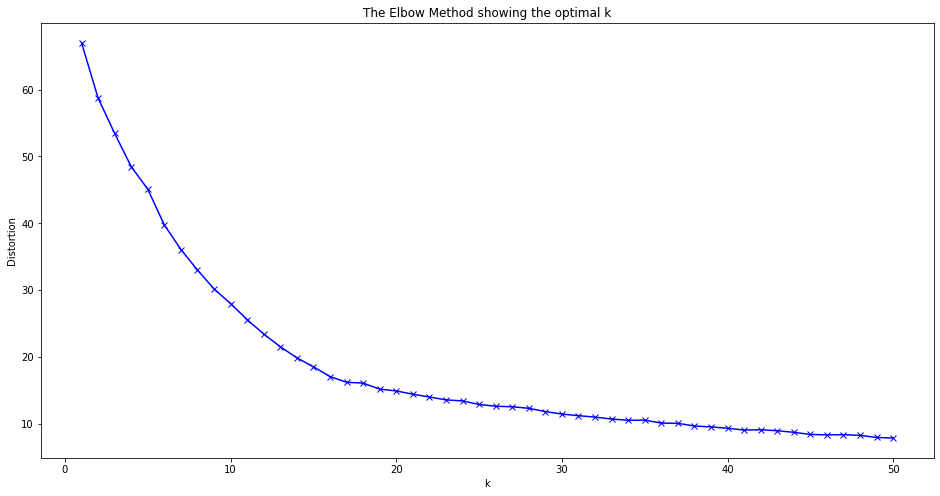

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [69]:
# kmeans setup
n_clusters = 20
model = KMeans(n_clusters = n_clusters, init='k-means++', n_init=50, random_state=2140)
model.fit(np.asarray(vec_text))



KMeans(n_clusters=20, n_init=50, random_state=2140)

In [70]:
common_words = model.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : esg, engagement, proxy, climate, invesco, initiative, voting, stewardship, network, philosophy
1 : market, year, inflation, fed, investor, rate, stock, growth, economy, economic
2 : nasdaq, qqqj, company, etf, gen, development, research, cap, growth, next
3 : position, allocation, macro, summary, outlook, factor, asset, neutral, sector, risky
4 : fed, inflation, rate, formally, target, stability, thinking, low, fund, quite
5 : plan, retirement, participant, saving, sponsor, employee, contribution, language, employer, defined
6 : technical, stock, opportunity, cap, playable, shakeout, sinister, score, oversold, shedding
7 : consumption, energy, fuel, liquid, opened, projected, barrel, grow, per, million
8 : personality, boardroom, presenter, type, workshop, keynote, resonate, others, presentation, diverse
9 : fixed, clawing, posting, income, benzel, tim, managed, quarter, nicely, settled
10 : company, tech, opportunity, smaller, software, analogue, sized, usual, service, commerce
11

In [71]:
predicted_clusters = model.predict(np.asarray(vec.transform(ok_status_df['cleaned_text']).todense()))
predicted_clusters

/Users/xaviergill/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([ 1,  1,  1,  5,  5,  1,  1,  1,  5,  5,  1, 12,  1,  5,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 16, 16,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  8,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 15,  1,  1,  3,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 15,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0, 14,  1,  1,  1,
        1,  1,  1,  4,  1,  1,  1,  5,  1,  1,  1,  1,  1,  1, 17, 17, 17,
       17,  1,  1, 11,  1,  1,  1,  1,  1, 19,  1, 19, 14,  1,  1,  1,  5,
        1,  1,  9,  1,  1, 11,  1,  1, 15,  1,  1,  8,  1,  1,  1,  1,  1,
        1,  1,  2,  1,  3,  1,  1,  1,  1,  1,  1,  1,  5,  1,  5,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  9, 12,  1,  1, 12,  1,  7,  1, 15,  9,  1,  1,  1,  1,
        1,  1,  1,  1, 10

In [72]:
prediction_df = ok_status_df.copy()
prediction_df['predicted_cluster'] = predicted_clusters

In [73]:
prediction_df.to_csv('data/predictions.csv')

In [74]:
# plot existing theme tag counts

tt_counts = prediction_df['Theme tags'].value_counts()
tt_counts

# tt_counts_df = prediction_df

Your practice                                               48
Macroeconomics & outlook                                    26
Research                                                    6 
Elections                                                   4 
Targeting growth;Factor investing                           3 
Factor investing                                            3 
Russia Ukraine crisis                                       3 
Targeting growth                                            3 
Solutions                                                   2 
Your clients                                                2 
Innovation                                                  2 
Investment solutions                                        2 
Your portfolio                                              2 
Coronavirus                                                 2 
College savings                                             2 
Investment solutions;Solutions                         

In [75]:
# plot predicted theme tag counts
ptt_counts = prediction_df['predicted_cluster'].value_counts()
ptt_counts

1     295
5     31 
15    9  
12    8  
17    5  
13    4  
9     3  
8     2  
3     2  
14    2  
16    2  
11    2  
19    2  
2     2  
10    2  
0     1  
4     1  
7     1  
18    1  
6     1  
Name: predicted_cluster, dtype: int64

In [76]:
# cluster mappings

cluster_map: dict = {
    0: 'Your Practice / IGC',
    1: 'Federal Reserve / Fiscal Policy',
    2: 'Equities / Emerging Markets',
    3: 'Debt',
    4: 'Economic Outlook & Insight',
    5: 'President / Executive Action / Elections', # confirmed
    6: 'Macroeoconomics', # confirmed
    7: 'Research', # defined contribution can also be here
    8: 'Your Practice / Audit', # similar to cluster 0
    9: 'Steelpath',
    10: 'Product Research', 
    11: 'Retirement',
    12: 'Equities',
    13: 'Trends',
    14: 'Real Estate',
    15: 'Growth & Innovation',
    16: 'Your Practice', # confirmed
    17: 'Fixed Income',
    18: 'Your Practice - Team Specific',
    19: 'Fixed Income & Municipals Updates'
}

In [77]:
def map_clusters(pred_cluster: int) -> str:
    return cluster_map[pred_cluster]


prediction_df['predicted_topic_tag'] = prediction_df['predicted_cluster'].progress_apply(map_clusters)

100%|██████████| 376/376 [00:00<00:00, 246916.91it/s]


In [78]:
prediction_df.to_csv('data/predictions.csv')

### Existing Topic Tag List

1. Alternatives
  a. Real estate
  b. Private equity
  c. Commodities
  d. Master limited partnerships
  e. Private credit
2. Markets and Economy
  a. Currency market
  b. Developed markets
  c. Market volatility
  d. Monetary policy
  e. Market outlook
3. Investing Basics
4. Equities
  a. Canadian equity
  b. Emerging market equity
  c. International and global equities
  d. US equity
5. College savings
6. Fixed Income
  a. Emerging market debt
  b. Global debt
  c. High yield
  d. Investment grade
  e. Money market and liquidity
  f. Multi sector
  g. Municipals
  h. Stable value
7. Factor Investing
8. Multi Asset
  a. Asset allocation
9. Investment Outlook
10. Insurance
11. ETF
12. Defined Contribution
  a. Plan governance
  b. Plan design
  c. Plan sponsor exchange
  d. Participant engagement
  e. Investment strategy
  f. Participant research
  g. Investment menu design
  h. Plan member research
  i. Plan member engagement
13. Defined Benefit
  a. Market and investing dynamics
  b. Aging demographics
  c. Plan evolution
  d. Risk and disruption
  e. Plan sponsor landscape
14. Legislative and Regulatory
  a. Washington update
15. Liability-driven Investing
16. Press Release
17. Product News
18. Retirement
19. Resources
20. Risk-based Investing
21. Target-date Investing
22. Invesco Global Consulting
  a. Asset gathering strategies
  b. Client conversations
  c. Communication strategies
  d. Constructing managing teams
  e. Retirement conversations
  f. New business development
  g. Client service
23. Innovation
24. Tax & Estate Planning
25. Separately Managed Accounts

### Running Model with Topic Count

In [79]:
# kmeans setup
n_clusters = 25
model = KMeans(n_clusters = n_clusters, init='k-means++', n_init=50, random_state=2140)
model.fit(np.asarray(vec_text))



KMeans(n_clusters=25, n_init=50, random_state=2140)

In [80]:
common_words = model.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : market, inflation, fed, year, investor, stock, rate, growth, economy, economic
1 : site, location, change, ground, greenspan, greg, gregory, grew, grid, grieving
2 : hsas, hsa, health, retirement, expense, employee, care, cover, saving, account
3 : tactical, wave, allocation, economic, across, regime, measure, recovery, global, translate
4 : company, tech, opportunity, smaller, software, analogue, sized, usual, service, commerce
5 : plan, retirement, participant, sponsor, saving, contribution, language, employee, option, fiduciary
6 : woman, men, retirement, language, gap, saving, protecting, found, placing, plan
7 : term, rate, bond, short, market, rise, october, steady, fall, benzel
8 : midstream, gas, month, amz, nyse, quarter, natural, bps, distribution, mlp
9 : position, allocation, macro, summary, outlook, factor, asset, neutral, sector, risky
10 : personality, boardroom, presenter, type, workshop, keynote, resonate, others, presentation, diverse
11 : market, historically, hi

In [81]:
predicted_clusters = model.predict(np.asarray(vec.transform(ok_status_df['cleaned_text']).todense()))
print(predicted_clusters)

/Users/xaviergill/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([ 0,  3,  0,  6,  5,  0,  0,  0,  2,  5,  0, 17, 21,  2,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 19,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 11, 11, 12,  0,  0,  0,  0,  0,  0, 22,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,
        0, 18,  0,  0,  0,  0, 24,  0,  0,  0,  0,  0,  0,  8,  0,  0,  9,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  5,  0,  3,  0,  0,  0,  0,  1,  1,  1,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,
        0,  0, 13,  0,  0,  0,  0,  0,  8,  0,  0, 10,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  5,  0,  5, 14,  0,
        0,  0,  0,  0,  0, 17,  0, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 13, 17,  0,  0, 17,  0,  0,  0,  8, 13,  0,  0,  0,  0,
        0,  0,  0,  0,  4

### Running Model with Subtopic Count

In [173]:
# kmeans setup
n_clusters = 45
model = KMeans(n_clusters = n_clusters, init='k-means++', n_init=50, random_state=2140)
predictions = model.fit_predict(np.asarray(vec_text))


In [174]:
pred_df = pd.DataFrame(predictions)
pred_df.value_counts()

0     259
21    27 
35    8  
20    6  
1     5  
3     4  
41    4  
5     3  
23    3  
2     3  
43    2  
39    2  
36    2  
19    2  
34    2  
31    2  
30    2  
26    2  
25    2  
22    2  
16    2  
15    2  
4     2  
14    2  
7     2  
12    2  
17    2  
10    2  
9     2  
18    1  
8     1  
42    1  
6     1  
40    1  
38    1  
37    1  
32    1  
33    1  
11    1  
29    1  
28    1  
27    1  
13    1  
24    1  
44    1  
dtype: int64

Viewing prediction array.

In [175]:
type(predictions)

numpy.ndarray

In [176]:
print(predictions)

[ 0 16  0 21 21  0  0  0 26 21  0 20 39 26  0  0  0  0  0 33  0  0  0  0
  0  0  0 12  0  0  0 30  0  0  0  0  0  0 14 14  0  0 37  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 34  0  0  0  0  0  0 11  0  0 19  0  0  0  0  0  0  0  0  0  0  0
  0  0 44 35  0  0  0 28  0  0  0  0  0  0  0  0  0  0  0  3  3  0  0  3
  0  0  0  0  0  0 21  0 16  0  0  0  0  1  1  1  1  0 15 22  0 36  0  0
 36 25  0 25  3 15  0  0 21  0  0  2 12 24 22  0  0 35  0  0  0  0  0  0
  0  0  0  4  0  0 19  4  8  0  0 10  0  0 21  0 21 31  0  0  0 27  0  0
  0  0 34  0  0  0  0  0  0  0  0  0  0  0  0  2 20  0  0 20  0  0  0 35
  2  0  0  0  0  0  0  0  5 43 43  0  0  0  0  0  0  0  5  0 39 35  0  0
  0  0  0  0  0  0  0 21 21 21 21  0  0  0  0  0  0  0  0  0  0  0  0  1
 17 35  0  0  0  0  0 40  0  0  0  0  0  0  0 17 23  0  0  0  0 21 10 35
  0  0  0  0  0  0  0  0  0 23  0  0  9 42  0 35  5  0  0 21  0  0  0  0
  0 18  0 38  0 13  0  7 23 30 21 20 21 21  0 21 21

Visualizing the distribution of predicted clusters.

(array([280.,  16.,  46.,  19.,  15.]),
 array([ 0. ,  8.8, 17.6, 26.4, 35.2, 44. ]),
 <BarContainer object of 5 artists>)

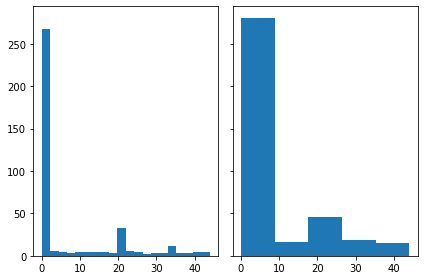

In [177]:
n_bins = 20

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(predictions, bins=n_bins)
axs[1].hist(predictions, bins=5)

Exporting predicted clusters as csv

In [185]:
subtopic_df = ok_status_df.copy()
subtopic_df['predicted_cluster'] = predictions
subtopic_df = subtopic_df.drop(columns=['Path', 'Last Modified', 'Tags', 'User role tags', 'Replication Status', 'status_codes', 'text', 'cleaned_text'])

In [186]:
subtopic_df

,Title,Topic Tags,Program tags,Theme tags,Content type tags,Full Path,predicted_cluster
0,Election 2020: The Senate is definitely in play,Legislative and regulatory;Washington update;Plan governance,Election 2020,Elections,Insight,https://www.invesco.com/us/en/insights/election-2020-the-senate-is-definitely-in-play.html,0
1,Tactical asset allocation outlook: November 2020,Multi Asset;Asset allocation;Markets and Economy,Solutions,Investment solutions,Insight,https://www.invesco.com/us/en/insights/tactical-asset-allocation-outlook-november-2020.html,16
2,2021 Investment Outlook: Implications for world GDP,Market outlook,NaN,Macroeconomics & outlook,Insight,https://www.invesco.com/us/en/insights/2021-outlook-implications-for-world-gdp.html,0
3,Shifting DC Times: Helping women close the retirement gap,Participant engagement;Defined contribution,Shifting DC Times,NaN,Insight,https://www.invesco.com/us/en/insights/shifting-dc-times-closing-the-retirement-savings-gap.html,21
4,Shifting DC Times: Fiduciary fails to avoid,Plan governance;Defined contribution,Shifting DC Times,NaN,Insight,https://www.invesco.com/us/en/insights/shifting-dc-times-five-fiduciary-fails.html,21
...,...,...,...,...,...,...,...
371,China: A changing dynamic,Markets and Economy,NaN,NaN,Insight,https://www.invesco.com/us/en/insights/china-a-changing-dynamic.html,0
372,We anticipate little impact to our portfolio if Russia invades Ukraine,Equities,NaN,Russia Ukraine crisis,Insight,https://www.invesco.com/us/en/insights/we-anticipate-little-impact-our-portfolio-russia-invades-ukraine.html,41
373,Markets react to Russian military operations against Ukraine,Markets and Economy,NaN,Russia Ukraine crisis,Insight,https://www.invesco.com/us/en/insights/markets-react-russian-military-operations-against-ukraine.html,41
374,Economic and asset class implications of the Russia-Ukraine crisis,Markets and Economy,NaN,Russia Ukraine crisis,Insight,https://www.invesco.com/us/en/insights/economic-asset-class-implications-russia-ukraine-crisis.html,41


In [187]:
subtopic_df.to_csv('data/subtopic_predictions.csv', index=False)

Showing list of top 10 weighted words in each cluster.

In [180]:
common_words = model.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : market, fed, year, inflation, investor, stock, economy, growth, team, investment
1 : site, location, change, ground, greenspan, greg, gregory, grew, grid, grieving
2 : fixed, clawing, posting, income, benzel, tim, managed, quarter, nicely, settled
3 : yield, bond, year, fed, treasury, rate, inflation, investor, higher, rise
4 : scenario, base, outlook, inflation, economic, acceleration, anticipates, tail, resurgence, pandemic
5 : debt, ceiling, limit, treasury, government, congress, measure, borrowing, bill, security
6 : blind, question, spot, financial, make, answer, profound, answered, aspiration, proposition
7 : estate, real, oldest, consume, connect, innovate, clic, somewhere, live, dennis
8 : outperform, region, asset, decelerate, reflation, continue, rotation, style, accommodation, weakness
9 : digital, blockchain, asset, cryptocurrencies, cryptocurrency, etf, investor, exploring, access, us
10 : variant, delta, vaccine, omicron, israel, country, vaccination, covid, effective

Saving common word list for all 45 clusters to csv

In [181]:
common_word_dict = dict()
for i, centroid in enumerate(common_words):
  w_list = [words[word] for word in centroid]
  common_word_dict[i] = w_list

In [182]:
# creating dataframe with pandas
subtopic_cw_df = pd.DataFrame(common_word_dict)
subtopic_cw_df

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,market,site,fixed,yield,scenario,debt,blind,estate,outperform,digital,...,midstream,module,objective,bond,emerging,qqq,russia,stagflation,company,certainty
1,fed,location,clawing,bond,base,ceiling,question,real,region,blockchain,...,month,professional,take,fed,market,nasdaq,ukraine,fed,tech,vaccine
2,year,change,posting,year,outlook,limit,spot,oldest,asset,asset,...,gas,client,unique,market,growth,innovative,oil,inflation,opportunity,tax
3,inflation,ground,income,fed,inflation,treasury,financial,consume,decelerate,cryptocurrencies,...,nyse,right,financial,yield,drive,unwavering,russian,price,smaller,negotiation
4,investor,greenspan,benzel,treasury,economic,government,make,connect,reflation,cryptocurrency,...,amz,uncertain,three,inflation,gravity,sector,gas,shortage,software,brexit
5,stock,greg,tim,rate,acceleration,congress,answer,innovate,continue,etf,...,quarter,financial,content,tech,withstand,company,sanction,nixon,analogue,greater
6,economy,gregory,managed,inflation,anticipates,measure,profound,clic,rotation,investor,...,natural,research,come,talley,global,savvy,price,semiconductor,sized,unlikely
7,growth,grew,quarter,investor,tail,borrowing,answered,somewhere,style,exploring,...,bps,matter,step,curve,rewarded,drawdown,europe,definition,usual,biden
8,team,grid,nicely,higher,resurgence,bill,aspiration,live,accommodation,access,...,distribution,resiliency,journey,stock,cheaper,innovation,commodity,supply,service,election
9,investment,grieving,settled,rise,pandemic,security,proposition,dennis,weakness,us,...,mlp,performer,discovery,announcement,contraction,tended,bank,embargo,commerce,uncertainty


In [183]:
# exporting to csv
subtopic_cw_df.to_csv('data/subtopic_top_words.csv', index=False)

### Evaluating Relative Model Performance

K-Means, much like its unsupervised siblings, is difficult to evaluate. Supervised and semi-supervised machine learning tasks have the privilage of having labeled data that can be trained on, tested with, and validated against. Unfortuntely, that is not true for our choice of unsupervized model.

This is not necessarily a drawback because our underlying business case does not call for a model that outputs accurate predictions, or predictions at all for that matter. The only thing we must do is provide analytical leadership and various project stakeholders with meaningful clusters that can be used to create tags based on the themes within the content of a given cluster.